In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
from tqdm import tqdm

print(os.listdir())
import matplotlib.pyplot as plt

['sampling_test.ipynb', 'large_twitch_edges.csv', 'social.txt', 'graph_example50.jpg', 'musae_facebook_edges.csv', 'social_to_adjacency.ipynb', 'graph_example125.jpg', 'social_graph_labels.txt', 'graph_example150.jpg', '.DS_Store', '.ipynb_checkpoints', 'graph_example100.jpg', 'graph_example175.jpg', 'social_node_labels.txt', 'artist_edges.csv', 'social_graph_indicator.txt', 'graph_example25.jpg', 'graph_example0.jpg', 'graph_example75.jpg', 'social_A.txt']


In [2]:
social_data = pd.read_csv("musae_facebook_edges.csv")
print(social_data.shape)
np.savetxt(r'social_A.txt', social_data.values, fmt='%d', delimiter=",\t")

(171002, 2)


In [3]:
G = nx.Graph()
for i in tqdm(range(social_data.shape[0])):
    G.add_edge(social_data.iloc[i, 0], social_data.iloc[i,1])
G = nx.convert_node_labels_to_integers(G)

100%|██████████| 171002/171002 [00:17<00:00, 9907.36it/s] 


(171002, 2)
22470
200
160000


  0%|          | 0/800 [00:00<?, ?it/s]

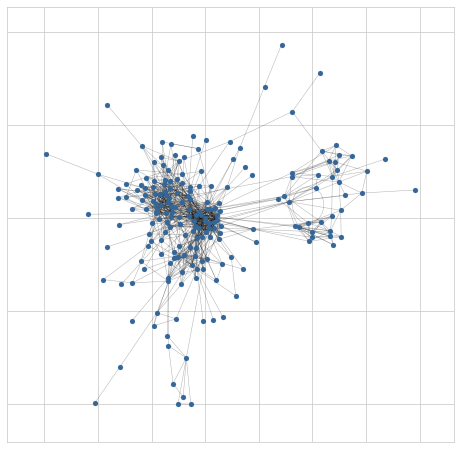

  3%|▎         | 24/800 [00:01<00:29, 26.71it/s]

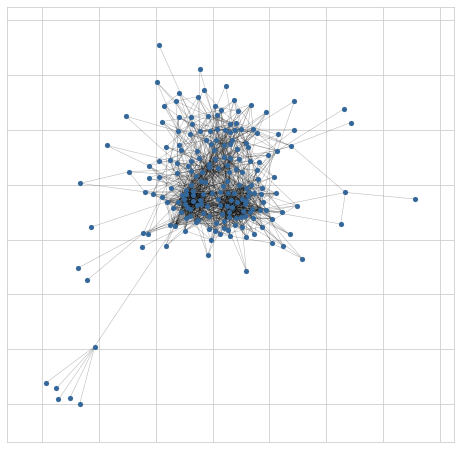

  6%|▌         | 47/800 [00:02<00:33, 22.51it/s]

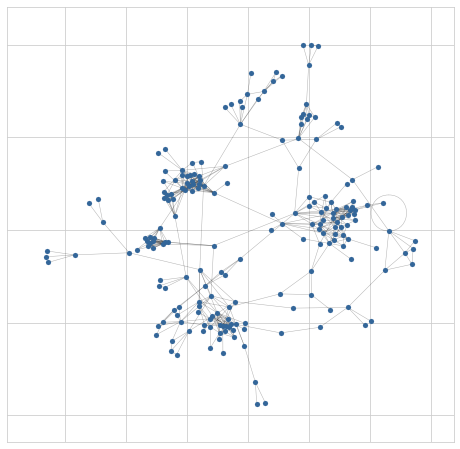

  9%|▉         | 75/800 [00:04<00:30, 23.91it/s]

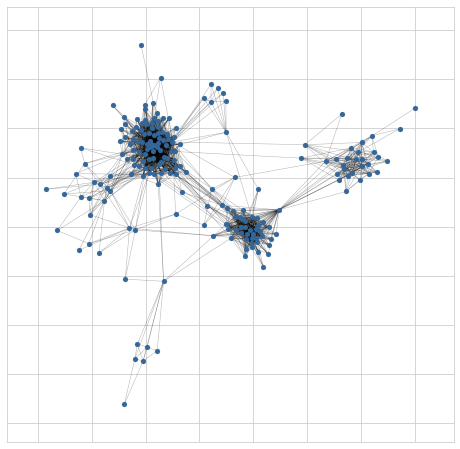

 12%|█▏        | 98/800 [00:06<00:30, 23.25it/s]

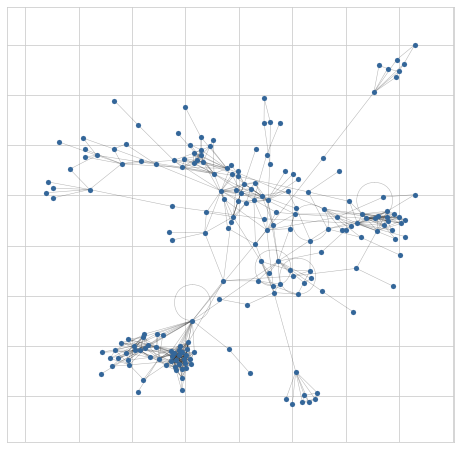

 16%|█▌        | 124/800 [00:07<00:27, 24.64it/s]

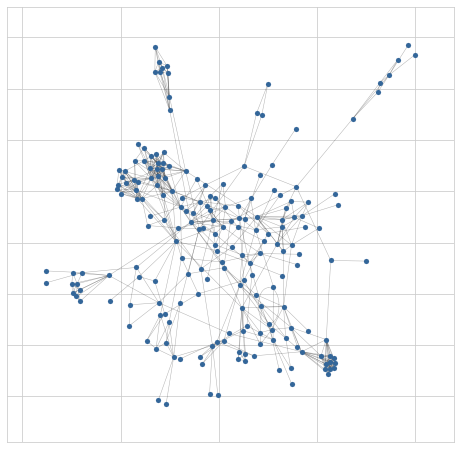

 18%|█▊        | 147/800 [00:09<00:29, 22.05it/s]

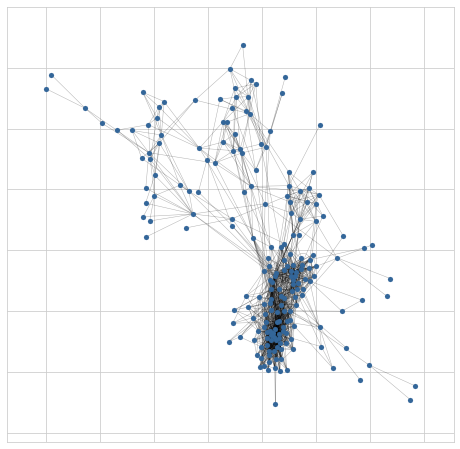

 22%|██▏       | 173/800 [00:10<00:27, 23.18it/s]

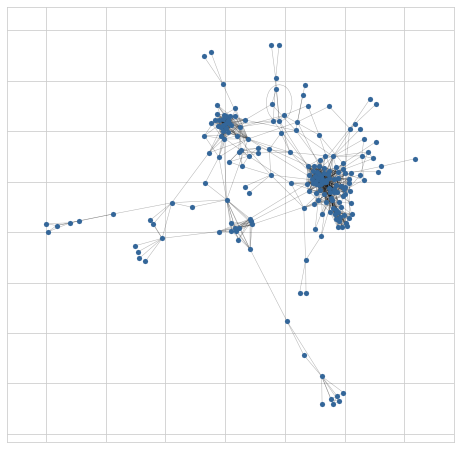

 25%|██▌       | 200/800 [00:12<00:23, 25.43it/s]

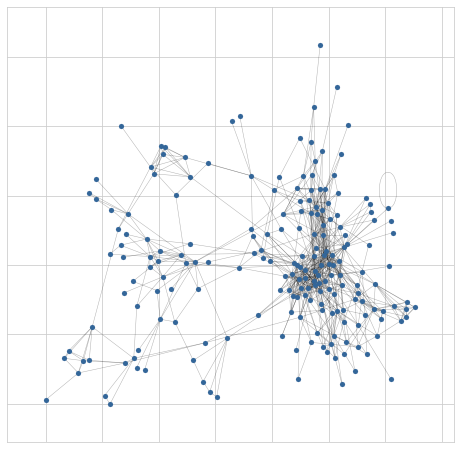

 28%|██▊       | 225/800 [00:13<00:24, 23.55it/s]

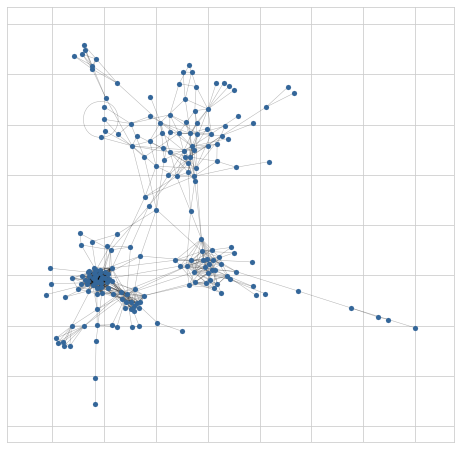

 31%|███       | 248/800 [00:15<00:24, 22.80it/s]

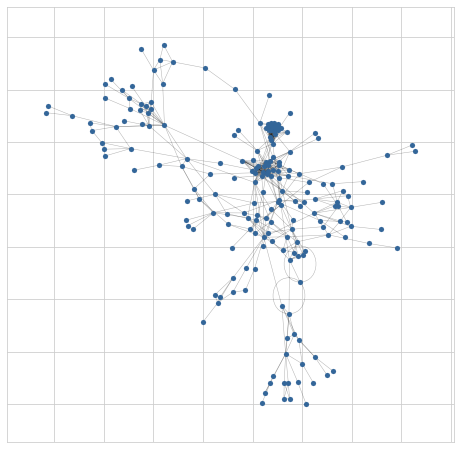

 34%|███▍      | 273/800 [00:16<00:21, 24.23it/s]

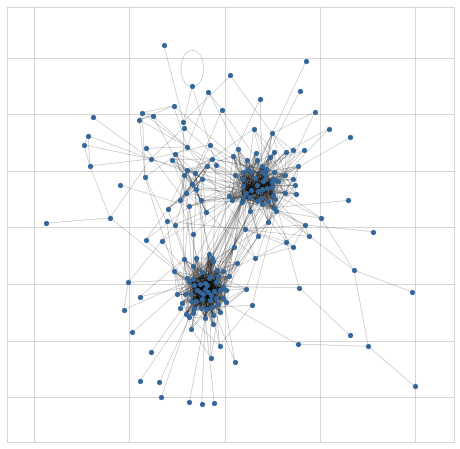

 37%|███▋      | 299/800 [00:18<00:21, 23.49it/s]

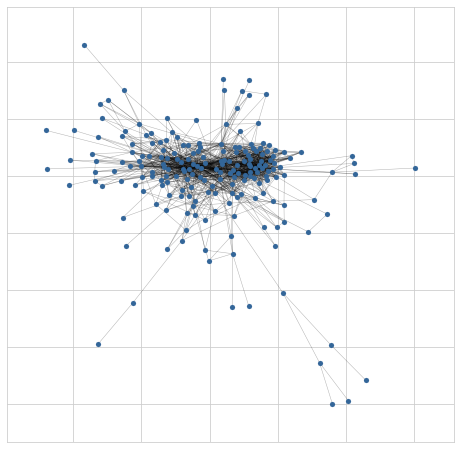

 41%|████      | 325/800 [00:20<00:19, 24.26it/s]

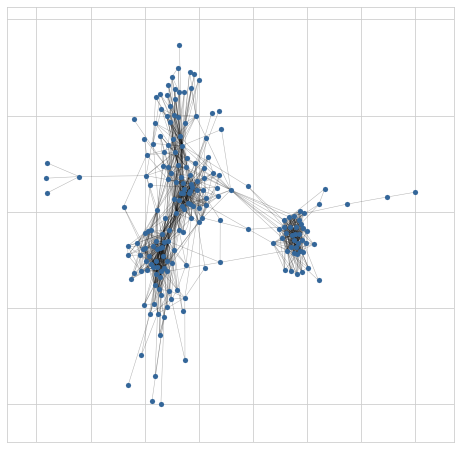

 44%|████▍     | 350/800 [00:21<00:18, 24.15it/s]

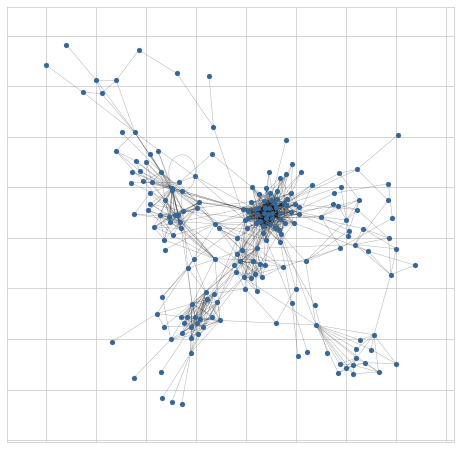

 47%|████▋     | 375/800 [00:23<00:23, 17.90it/s]

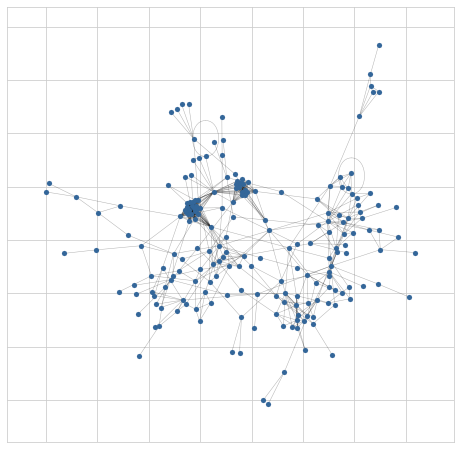

 50%|████▉     | 399/800 [00:26<00:19, 20.40it/s]

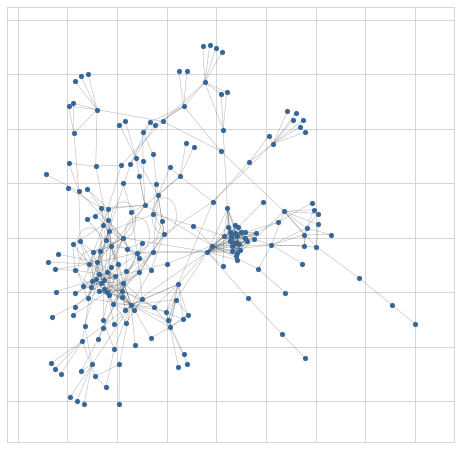

 53%|█████▎    | 423/800 [00:27<00:20, 18.06it/s]

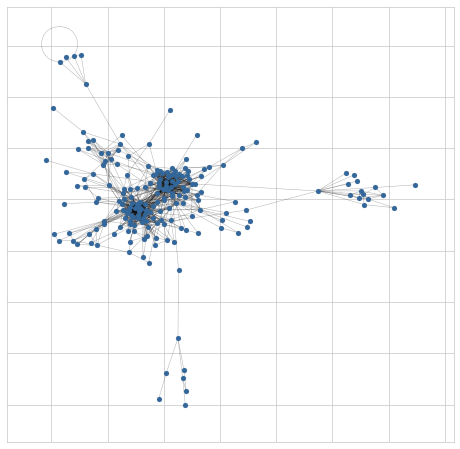

 56%|█████▌    | 449/800 [00:30<00:18, 18.72it/s]

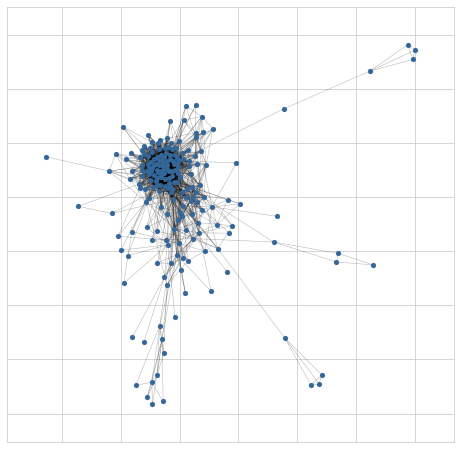

 59%|█████▉    | 475/800 [00:32<00:22, 14.70it/s]

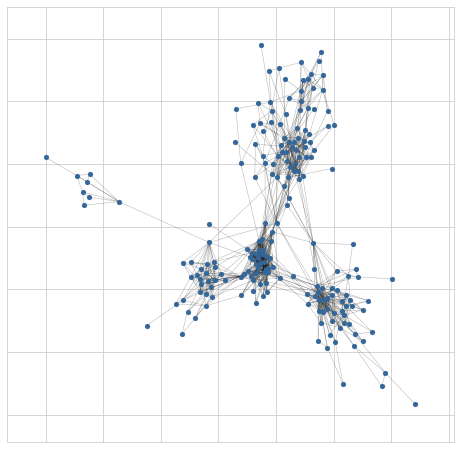

 62%|██████▏   | 499/800 [00:35<00:20, 14.76it/s]

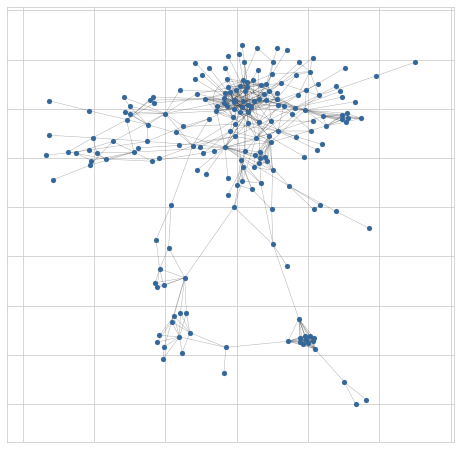

 66%|██████▌   | 525/800 [00:38<00:16, 16.45it/s]

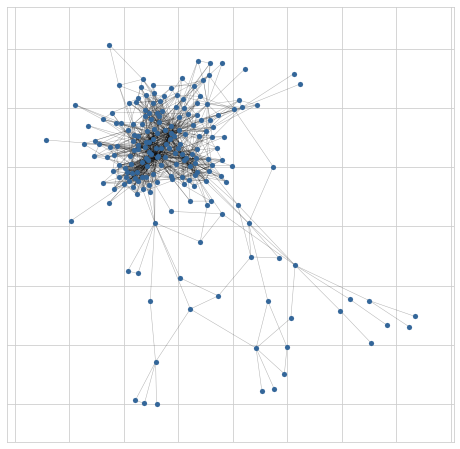

 69%|██████▊   | 549/800 [00:40<00:12, 20.60it/s]

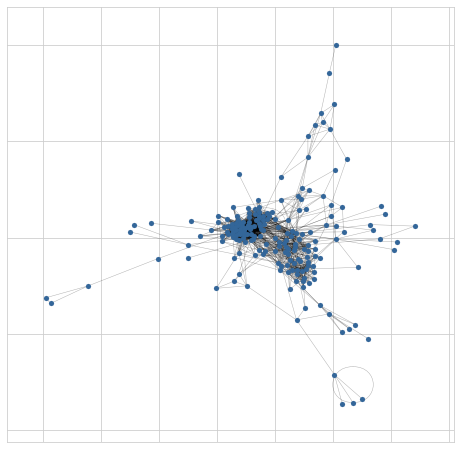

 72%|███████▏  | 574/800 [00:41<00:10, 22.37it/s]

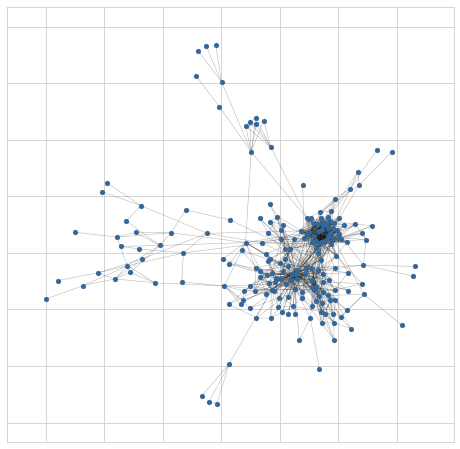

 75%|███████▍  | 599/800 [00:44<00:10, 18.71it/s]

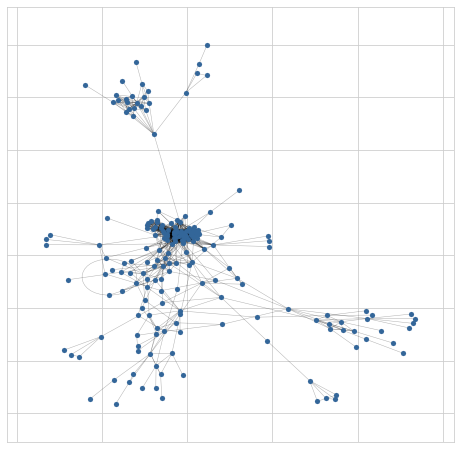

 78%|███████▊  | 624/800 [00:45<00:07, 23.11it/s]

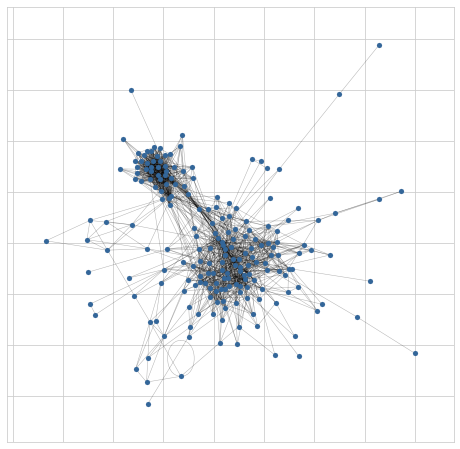

 81%|████████  | 649/800 [00:47<00:06, 22.89it/s]

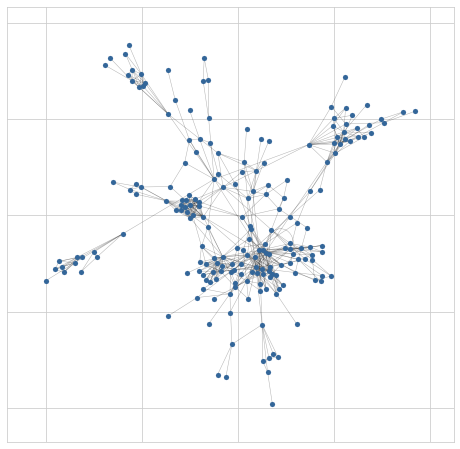

 84%|████████▍ | 673/800 [00:48<00:05, 24.73it/s]

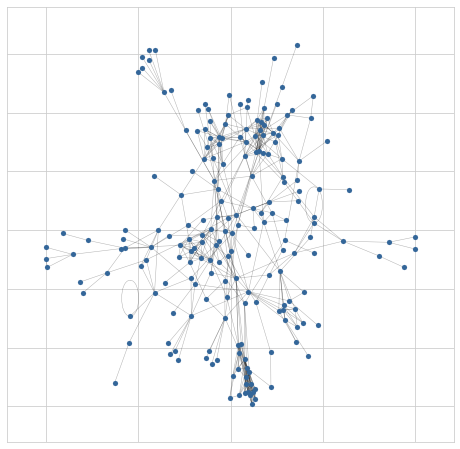

 88%|████████▊ | 700/800 [00:50<00:04, 23.48it/s]

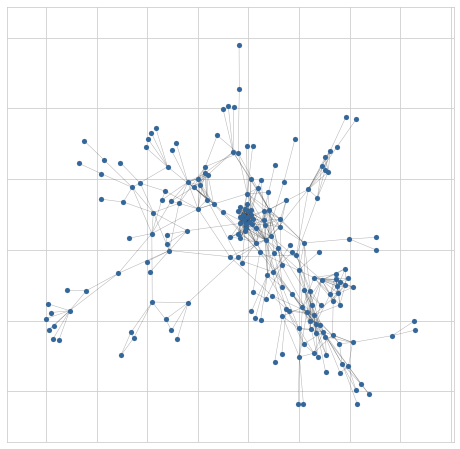

 90%|█████████ | 723/800 [00:52<00:03, 24.07it/s]

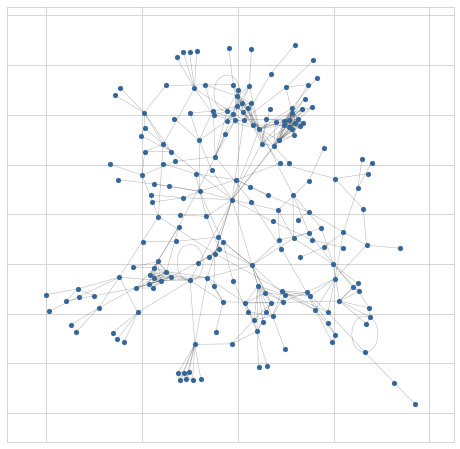

 94%|█████████▎| 749/800 [00:53<00:02, 24.30it/s]

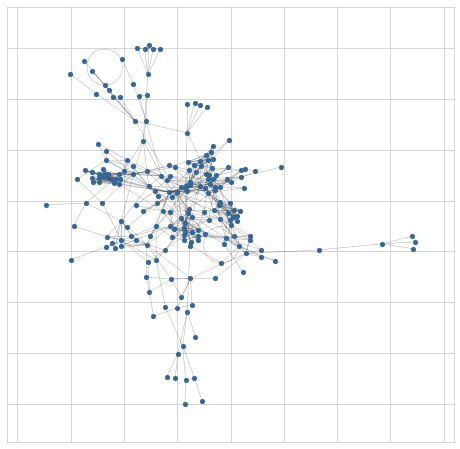

 97%|█████████▋| 774/800 [00:55<00:01, 25.14it/s]

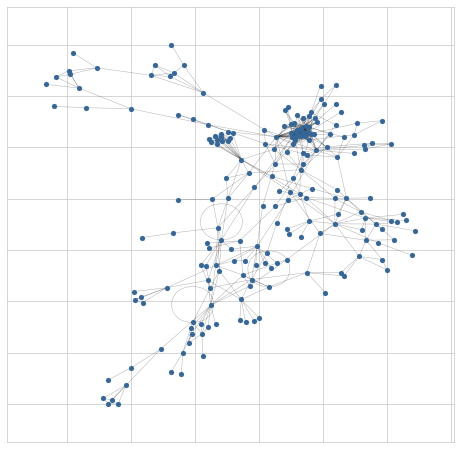

100%|██████████| 800/800 [00:56<00:00, 14.11it/s]

(929613, 2)
(160000,)


In [4]:
from littleballoffur import ForestFireSampler, MetropolisHastingsRandomWalkSampler, RandomWalkSampler, DiffusionSampler
print(social_data.shape)
n_nodes = np.unique(social_data.values).shape[0]
print(n_nodes)
n_graphs = 800

graph_ind_array = np.zeros(n_nodes)
n_per_graph = 200#int(n_nodes / n_graphs)

print(n_per_graph)

total_n = n_per_graph * n_graphs

print(total_n)
graph_ind_array = np.zeros(total_n)


#number_of_nodes = int(0.5*graph.number_of_nodes())


for i in tqdm(range(n_graphs)):
    
    offset_index = i * n_per_graph
    sampler = ForestFireSampler(number_of_nodes = n_per_graph,#np.random.randint(, n_per_graph),
                               seed = np.random.randint(1, 1e6))
    new_graph = sampler.sample(G)
    
    # print(len(list(new_graph.nodes())))
    
    new_graph = nx.convert_node_labels_to_integers(new_graph, first_label=offset_index)
    
    graph_ind_array[offset_index:(i+1) * n_per_graph] = i+1
    
    nodes = list(new_graph.nodes())
    
    if i ==0:
        graph_adj = np.array(new_graph.edges())
        graph_ind_array = np.array(np.full(len(nodes), i+1))
    else:
        graph_adj = np.append(graph_adj, np.array(new_graph.edges()), axis = 0)
        graph_ind_array = np.append(graph_ind_array, np.array(np.full(len(nodes), i+1)))
    
    if i % 25 == 0:
        plt.figure(figsize = (8,8))
        
        pos = nx.spring_layout(
          new_graph, k=0.1, iterations=100)
        
        
        nx.draw_networkx_nodes(
          new_graph,
          pos,
          node_size=25,
          node_color='#336699',
          alpha=1,
          linewidths=0.2)#,
          # font_size=1.5)
        nx.draw_networkx_edges(new_graph, pos, alpha=0.3, width=0.5)

        plt.savefig(f"graph_example{i}.jpg")
        plt.show()

print(graph_adj.shape)
print(graph_ind_array.shape)

total_n = graph_ind_array.shape[0]

In [13]:
data_dir =        "/home/alex/Documents/Project_CDT/GRAN_social/data/FACEBOOK/"

# for file in os.listdir(data_dir):
#     print(file)
#     if "DUMMY" in file:
#         shutil.rmtree(f"{data_dir}{file}")

np.savetxt(f'{data_dir}FACEBOOK_A.txt', graph_adj, fmt='%d', delimiter=",\t")
np.savetxt(f'{data_dir}FACEBOOK_graph_indicator.txt',graph_ind_array, fmt="%d")

np.savetxt(f'{data_dir}FACEBOOK_node_labels.txt', np.arange(1, total_n+1), fmt = "%d")
print(np.arange(1, total_n+1).shape)

np.savetxt(f'{data_dir}FACEBOOK_graph_labels.txt', np.ones(total_n), fmt = "%d")
print(np.ones(total_n).shape)


        
# np.savetxt(r'social_A.txt', graph_adj, fmt='%d', delimiter=",\t")
# np.savetxt(r'social_graph_indicator.txt',graph_ind_array, fmt="%d")

# np.savetxt(r'social_node_labels.txt', np.arange(1, total_n+1), fmt = "%d")
# print(np.arange(1, total_n+1).shape)

# np.savetxt(r'social_graph_labels.txt', np.ones(total_n), fmt = "%d")
# print(np.ones(total_n).shape)

(160000,)
(160000,)


In [6]:
# print(social_data.shape)
# n_nodes = np.unique(social_data.values).shape[0]
# print(n_nodes)
# n_graphs = 100

# graph_ind_array = np.zeros(n_nodes)
# n_per_graph = int(n_nodes / n_graphs)

# print(n_per_graph)

# G_ids = []

# for i in range(n_graphs):
    
#     G2 = nx.Graph()

#     for node in G.nodes():
        
#         neighbours = list(G.neighbors(node))


In [7]:


# # for i in range(n_graphs):
    
# #     graph_ind_array[i*n_per_graph : (i+1)*n_per_graph] = i+1
    
# #     if i == n_graphs - 1:
# #         graph_ind_array[(i+1)*n_per_graph:] = i+1

# np.savetxt(r'social_graph_indicator.txt',graph_ind_array, fmt="%d")
# print(graph_ind_array.shape)

In [8]:
# np.savetxt(r'social_node_labels.txt', np.arange(1, n_nodes+1), fmt = "%d")
# print(np.arange(1, n_nodes+1).shape)

In [9]:
# np.savetxt(r'social_graph_labels.txt', np.ones(n_nodes), fmt = "%d")
# print(np.ones(n_nodes).shape)

In [10]:
# adj = pd.read_csv("/Users/alexdavies/Documents/Year_1/Project/GRAN_social/data/DD/DD_A.txt", delimiter = ",|\n")
# adj.shape

In [11]:
# g_ind = pd.read_csv("/Users/alexdavies/Documents/Year_1/Project/GRAN_social/data/DD/DD_graph_indicator.txt", delimiter = ",|\n")
# g_ind.shape

In [12]:
# n_lab = pd.read_csv("/Users/alexdavies/Documents/Year_1/Project/GRAN_social/data/DD/DD_node_labels.txt", delimiter = ",|\n")
# n_lab.shape